# Actor-Critic TD(0) Policy-Gradient

Actor-Critic TD(0) (or 1-step Temporal Difference) is essentially the Reinforce Baseline algorithm, but with bootstrapping. In the Reinforce Baseline algorithm the state-value function, $\hat{v}(S_{t}, w)$, was used on the current state to find the error, $\delta$, between the actual return and expected return. In Actor-Critic TD(0) the state-value function is also used on the next state, $\hat{v}(S_{t+1}, w)$, to find the bootstrapped return, $G_{t:t+1}$, which is used inplace of the actual return, $G_t$. This allows the agent to learn quicker and learn during the episode, essentially unlocking all the benifits of Temporal Difference learning methods. 

The error, $\delta$, is now given by:
$$\delta_t \leftarrow R + \gamma\hat{v}(S_{t+1}, w) - \hat{v}(S_{t}, w),$$
where $S_{t}$ is the current state, $S_{t+1}$ is the next state, $R$ is the current reward, $\gamma$ is the discount rate, and $w$ are the parameters of the state-value function $\hat{v}.$
The state-value function parameter update becomes:
$$w \leftarrow w + \alpha^{w}\nabla\hat{v}(S_t, w)\delta_t,$$
where $\alpha$ is the step-size or learning rate. The policy function update now becomes:
$$\theta \leftarrow \theta + \alpha^{\theta} \gamma^{t} \nabla_\theta \log(\pi_\theta(a_t | s_t))\delta_t.$$

For more information on the Actor-Critic TD(0) algorithm, see chapter 13.5 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf).


In [1]:
import os
import gymnasium as gym
import numpy as np
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import jax
import flax.linen as nn
from jax import random
from jax import grad, value_and_grad
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

In [2]:
# Type of environment, options include:
# CartPole-v1
ENV_TYPE = "CartPole-v1"

# Save videos from training
SAVE_VIDEOS = False
VIDEOS_ROOT_DIR = './videos/actor-critic/'

In [86]:
# Create the environment
env = gym.make(ENV_TYPE, render_mode="rgb_array")

# Number of possible states and actions
num_actions = env.action_space.n
obs_dims = env.observation_space.shape
obs_upper_bounds = env.observation_space.high
obs_lower_bounds = env.observation_space.low

## Create The Policy 

In [87]:
class _policy_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(64)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(num_actions)(x)
        return jax.nn.softmax(x)

# Create the model object
policy_fn = _policy_fn()
# Display the model details
dummy_x, _ = env.reset()
rng_key = random.PRNGKey(64)
print(policy_fn.tabulate(rng_key, dummy_x))


                               _policy_fn Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module     ┃ inputs       ┃ outputs      ┃ params                  ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ _policy_fn │ float32[4]   │ float32[2]   │                         │
├─────────┼────────────┼──────────────┼──────────────┼─────────────────────────┤
│ Dense_0 │ Dense      │ float32[4]   │ float32[256] │ bias: float32[256]      │
│         │            │              │              │ kernel: float32[4,256]  │
│         │            │              │              │                         │
│         │            │              │              │ 1,280 (5.1 KB)          │
├─────────┼────────────┼──────────────┼──────────────┼─────────────────────────┤
│ Dense_1 │ Dense      │ float32[256] │ float32[64]  │ bias: float32[64]       │
│         │            │   

In [88]:
class _value_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Create the model object
value_fn = _value_fn()
# Display the model details
print(value_fn.tabulate(rng_key, dummy_x))


                              _value_fn Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module    ┃ inputs       ┃ outputs      ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ _value_fn │ float32[4]   │ float32[1]   │                        │
├─────────┼───────────┼──────────────┼──────────────┼────────────────────────┤
│ Dense_0 │ Dense     │ float32[4]   │ float32[256] │ bias: float32[256]     │
│         │           │              │              │ kernel: float32[4,256] │
│         │           │              │              │                        │
│         │           │              │              │ 1,280 (5.1 KB)         │
├─────────┼───────────┼──────────────┼──────────────┼────────────────────────┤
│ Dense_1 │ Dense     │ float32[256] │ float32[1]   │ bias: float32[1]       │
│         │           │              │             

In [89]:
def policy_loss_fn(policy_variables, value_variables, state, next_state, action, reward, gamma, running_discount):
    value = value_fn.apply(value_variables, state)[0]
    next_value = value_fn.apply(value_variables, next_state)[0]
    td_error = (reward + gamma*next_value) - value

    action_dist = policy_fn.apply(policy_variables, state)
    prob = action_dist[action]
    log_prob = jnp.log(prob)

    loss = -(running_discount * td_error * log_prob)

    return loss 

In [90]:
def value_loss_fn(variables, state, next_state, reward, gamma):
    value = value_fn.apply(variables, state)[0]
    next_value = value_fn.apply(variables, next_state)[0]
    td_error = (reward + gamma*next_value) - value
    loss = td_error * value
    return loss 

## Learn The Optimal Action-Value Function

In [91]:
# Number of episodes to train on
episodes = 51
# Sliding window for episode evaluation (needs to be less than episodes)
episode_window = 5
# Discount ratio
gamma = 0.99
# Step size
policy_alpha = 0.0001
value_alpha = 0.0001

policy_variables = policy_fn.init(rng_key, dummy_x)
policy_optimizer = optax.adam(learning_rate=policy_alpha)
policy_opt_state = policy_optimizer.init(policy_variables)

value_variables = value_fn.init(rng_key, dummy_x)
value_optimizer = optax.adam(learning_rate=value_alpha)
value_opt_state = value_optimizer.init(value_variables)

env = gym.make(ENV_TYPE, render_mode="rgb_array")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)

if SAVE_VIDEOS:
    os.makedirs(VIDEOS_ROOT_DIR, exist_ok=True)
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder=VIDEOS_ROOT_DIR,
        episode_trigger=lambda episode: episode % 10 == 0,
        video_length=0,
        name_prefix=ENV_TYPE
        )

for episode in range(1, episodes+1):
    terminated, truncated = False, False
    reward = 0
    # Accumulated discount
    running_discount = 1.0
    state, info = env.reset()
    # Generate an episode following the policy
    while not (terminated or truncated):
        # Select the action following the parametrized policy
        action_dist = policy_fn.apply(policy_variables, state)
        action_dist = np.array(action_dist).astype(np.float64)
        # Divide by the total to ensure the values sum to one
        action_dist /= action_dist.sum()
        action = np.random.choice(np.arange(num_actions), p=action_dist)
        # Take the action and observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(int(action))

        value_loss, value_grads = value_and_grad(value_loss_fn, argnums=0)(value_variables, state, next_state, reward, gamma)
        value_updates, value_opt_state = value_optimizer.update(value_grads, value_opt_state, value_variables)
        value_variables = optax.apply_updates(value_variables, value_updates)        

        policy_loss, policy_grads = value_and_grad(policy_loss_fn, argnums=0)(policy_variables, value_variables, state, next_state, action, reward, gamma, running_discount)
        policy_updates, policy_opt_state = policy_optimizer.update(policy_grads, policy_opt_state, policy_variables)
        policy_variables = optax.apply_updates(policy_variables, policy_updates)

        running_discount *= gamma
        state = next_state
            

    if episode % episode_window == 0:
        print(f'Episode {episode} Average Returns: {np.mean(np.array(env.return_queue).flatten()[-episode_window:]) :.2f}')

/home/ubuntu20/anaconda3/envs/flax/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-0.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-0.mp4


Episode 5 Average Returns: 18.80
Episode 10 Average Returns: 32.40
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-10.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-10.mp4


Episode 15 Average Returns: 48.00
Episode 20 Average Returns: 78.20
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-20.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-20.mp4
Episode 25 Average Returns: 69.80
Episode 30 Average Returns: 68.80
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-30.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-30.mp4
Episode 35 Average Returns: 62.20
Episode 40 Average Returns: 64.00
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-40.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-40.mp4
Episode 45 Average Returns: 66.80
Episode 50 Average Returns: 81.80
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-50.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/reinforce_actor-critic/CartPole-v1-episode-50.mp4


## Plot The Results

For cartpole rewards are assigned for the time spent in a non-terminal state. The episode length and rewards will be identical in this case.

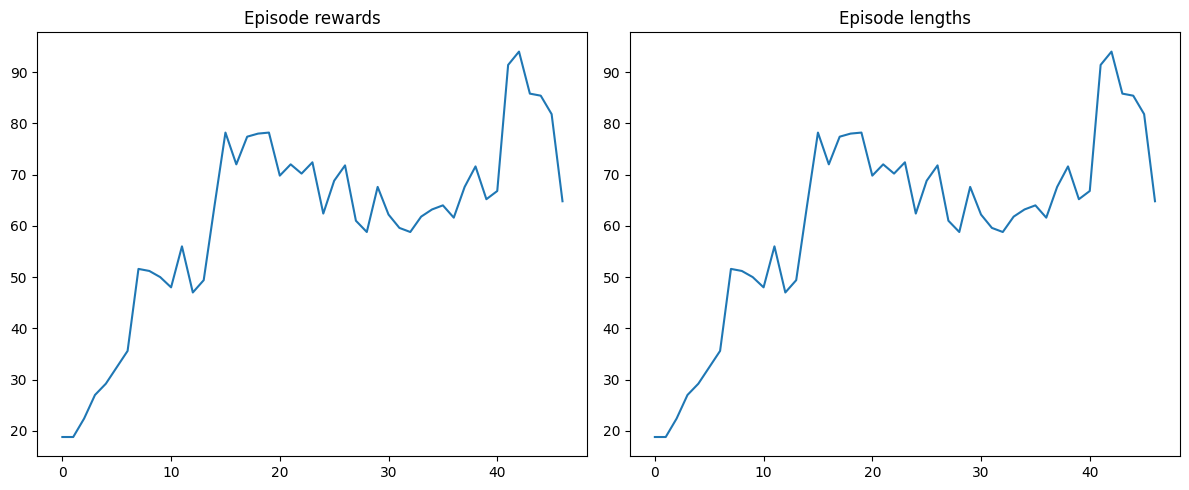

In [99]:
# Code used from: https://gymnasium.farama.org/tutorials/blackjack_tutorial/#visualizing-the-training
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()

## Training Episode Videos

### Episode 0

In [3]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-0.mp4")

### Episode 10

In [4]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-10.mp4")

### Episode 20

In [5]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-20.mp4")

### Episode 30

In [6]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-30.mp4")

### Episode 40

In [7]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-40.mp4")

### Episode 50

In [8]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-50.mp4")